# Image Super Resolution Inference with OpenVINO

[OpenVINO Inference Engine Samples ](https://docs.openvinotoolkit.org/latest/openvino_docs_IE_DG_Samples_Overview.html)

To load environment varible, run 
```
source /opt/intel/openvino_2021/bin/setupvars.sh
```
before run jupyter lab.

In [1]:
import sys
from time import time
import numpy as np
import tensorflow as tf
from openvino.inference_engine import IECore
import matplotlib.pyplot as plt

In [2]:
def param_to_string(metric):
    if isinstance(metric, (list, tuple)):
        return ", ".join([str(val) for val in metric])
    elif isinstance(metric, dict):
        str_param_repr = ""
        for k, v in metric.items():
            str_param_repr += f"{k}: {v}\n"
        return str_param_repr
    else:
        return str(metric)

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
ie = IECore()
print("Available devices:")
for device in ie.available_devices:
    print(f"\tDevice: {device}")
    """
    print("\tMetrics:")
    for metric in ie.get_metric(device, "SUPPORTED_METRICS"):
        try:
            metric_val = ie.get_metric(device, metric)
            print(f"\t\t{metric}: {param_to_string(metric_val)}")
        except TypeError:
            print(f"\t\t{metric}: UNSUPPORTED TYPE")

    print("\n\tDefault values for device configuration keys:")
    for cfg in ie.get_metric(device, "SUPPORTED_CONFIG_KEYS"):
        try:
            cfg_val = ie.get_config(device, cfg)
            print(f"\t\t{cfg}: {param_to_string(cfg_val)}")
        except TypeError:
            print(f"\t\t{cfg}: UNSUPPORTED TYPE")
    """
    print()

Available devices:
	Device: CPU

	Device: GNA

	Device: GPU



In [4]:
#model = '/home/aslan/workspace/openvino/rrdn/saved_model.xml'
model = '/home/aslan/workspace/openvino/fsrcnn/saved_model.xml'
print(f"Loading network:\n\t{model}")
net = ie.read_network(model=model)
exec_net = ie.load_network(network=net, device_name='GPU')

# create one inference request for asynchronous execution
request_id = 0
infer_request = exec_net.requests[request_id]

input_blob = next(iter(net.input_info))
out_blob = next(iter(net.outputs))

print(net)
print(input_blob)
print(out_blob)

Loading network:
	/home/aslan/workspace/openvino/fsrcnn/saved_model.xml
lr_input
StatefulPartitionedCall/model_1/conv2d_transpose/BiasAdd/Add


In [5]:
net.input_info[input_blob].input_data.shape

[1, 3, 540, 960]

In [6]:
data = tf.io.read_file('/home/aslan/workspace/CSGO_valid_LR_bicubic/X2/02600x2.png')
image = tf.io.decode_image(data)
image = tf.image.convert_image_dtype(image, tf.float32)

input_lr = tf.transpose(image, perm=[2, 0, 1])
#print(input_lr)
input_lr = tf.reshape(input_lr, [1, 3, 540, 960])
#print(input_lr.numpy())


#plt.figure(figsize = [16, 16])
#plt.imshow(image)
start = time()
infer_request.infer({input_blob: input_lr.numpy()})
res = infer_request.output_blobs[out_blob]
elapsed_time = time() - start
print(f'took {elapsed_time}s')

took 0.523078441619873s


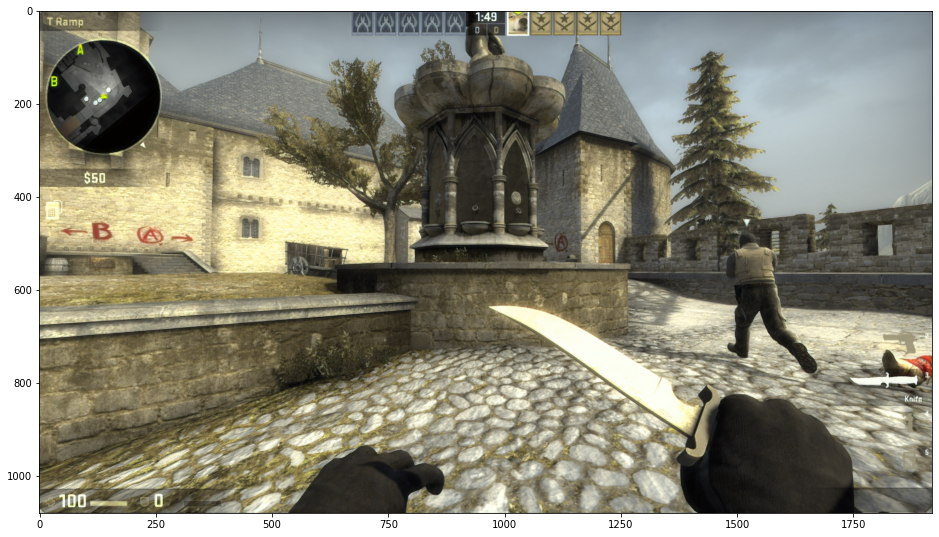

In [7]:
#res.buffer
img = res.buffer[0]
img = tf.transpose(img, perm=[1, 2, 0])
img = np.float32(tf.clip_by_value(img, 0.0, 1.0))
plt.figure(figsize = [16, 16])
plt.imshow(img)